# The Continuous Epistasis Model for Gene-by-Environment Interactions

The following code trains and evaluates the continuous epistasis model on up to fourth-order gene-gene-environment-environment data. It uses single- and pairwise CRISPRi perturbations to relate gene expression (relative repression) to growth rate in a variety of media conditions. Single-perturbation growth rate relationships are modeled with two- or four-parameter sigmoidal functions, and perturbation coupling is accounted for using two coupling constants for every pair. The resulting model is assessed by its RMSD relative to a coupling-insensitive Null model. A subsampled model trained on only 20% of the available pairwise perturbation data performs similarly to the full model, supporting a sparse sampling strategy as a way to improve throughput in future experiments. Finally, predictions made using pairwise couplings alone are robust to third- and fourth-order combinations of perturbations.

3/7/22 - Phil Brown
8/7/22 - Ryan Otto
2/17/23 - Ryan Otto

### Import packages and libraries

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
from sklearn.utils import resample as bootstrap
import itertools
import warnings
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'
input_path = 'input_files'
output_path = 'intermediate_files'
bootstrap_path = 'input_files/bootstrapped_files'
optimization_path = 'input_files/optimization_files'
figure_path = 'Figures'
perturb_list = ['thymidine', 'methionine', 'folA_KD', 'thyA_KD']

### Import data

In [3]:
with open(f'{input_path}/env_norm_ind_GR_A.pickle', 'rb') as handle:
    env_norm_ind_GR_A = pickle.load(handle)
with open(f'{input_path}/env_norm_ind_GR_B.pickle', 'rb') as handle:
    env_norm_ind_GR_B = pickle.load(handle)
with open(f'{output_path}/231012_growth_rates_mean.pickle', 'rb') as handle:
    growth_rates_mean = pickle.load(handle)
with open(f'{output_path}/231012_growth_rates_std.pickle', 'rb') as handle:
    growth_rates_std = pickle.load(handle)
with open(f'{output_path}/231012_repression_mean_subset.pickle', 'rb') as handle:
    repression_mean_subset = pickle.load(handle)
with open(f'{output_path}/231012_repression_ind_subset.pickle', 'rb') as handle:
    repression_ind_subset = pickle.load(handle)
with open(f'{output_path}/231012_repression_sem_subset.pickle', 'rb') as handle:
    repression_sem_subset = pickle.load(handle)
with open(f'{output_path}/231012_growth_rates_reps.pickle', 'rb') as handle:
    growth_rates_reps = pickle.load(handle)
with open(f'{bootstrap_path}/230303_env_hill_est.pickle', 'rb') as handle:
    hill_est = pickle.load(handle)
with open(f'{bootstrap_path}/230303_env_pair_avals.pickle', 'rb') as handle:
    pair_avals = pickle.load(handle)
with open(f'{bootstrap_path}/230303_env_pair_avals_sub.pickle', 'rb') as handle:
    pair_avals_sub = pickle.load(handle)
with open(f'{optimization_path}/230307_reg_opt_rmsd.pickle', 'rb') as handle:
    regularization_rmsd = pickle.load(handle)
with open(f'{optimization_path}/230307_sub_opt_rmsd.pickle', 'rb') as handle:
    subsampling_rmsd = pickle.load(handle)

## Set up perturbation dictionaries for single gene knockdowns and environmental additives

In [4]:
perturb_dict, perturb_dict_ind, env_growth_rate_reps = {}, {}, {}
perturb_dict['thymidine'] = [0, 0.05, 1, 2, 5, 10, 50]
perturb_dict['methionine'] = [0, 0.01, 0.02, 0.05, 0.1, 0.3, 1.0]
perturb_dict['folA_KD'] = list(repression_mean_subset['folA'].values())
perturb_dict['thyA_KD'] = list(repression_mean_subset['thyA'].values())
perturb_dict_ind['folA_KD'] = repression_ind_subset['folA_KD']
perturb_dict_ind['thyA_KD'] = repression_ind_subset['thyA_KD']
env_growth_rate_reps['thymidine'] = {}
for val in perturb_dict['thymidine']:
    if val == 0:
        key = 'M9'  # Change format to match input data labels
    elif len(str(val)) == 1:
        key = f'0{val}.00T0.000M'
    elif len(str(val)) == 2:
        key = f'{val}.00T0.000M'
    else:
        key = f'0{val}T0.000M'
    if key in env_norm_ind_GR_B:
        env_growth_rate_reps['thymidine'][val] = env_norm_ind_GR_B[key]
    else:
        env_growth_rate_reps['thymidine'][val] = env_norm_ind_GR_A[key]
env_growth_rate_reps['methionine'] = {}
for val in perturb_dict['methionine']:
    if val == 0:
        key = 'M9'
    elif len(str(val)) == 3:
        key = f'00.00T{val}00M'
    else:
        key = f'00.00T{val}0M'
    if key in env_norm_ind_GR_B:
        env_growth_rate_reps['methionine'][val] = env_norm_ind_GR_B[key]
    else:
        env_growth_rate_reps['methionine'][val] = env_norm_ind_GR_A[key]

### Define analysis functions

In [5]:
def residuals_growth_rate(params, true_gr, perturbations):
    """Function to compute residuals between predicted and measured growth rates.
    Arguments:
    params: Growth rate parameters for each perturbation
    true_gr: Actual growth rate measurements
    perturbations: Repression values for each perturbation
    Returns:
    err: Residual bewteen prediction and measured growth rates
    """
    gr_est = growth_rate(perturbations, params)
    err = np.array(true_gr - gr_est)
    err = err[~np.isnan(err)]
    return err


def growth_rate(perturbations, params):
    """Calculates an expected growth rate using a sigmoidal formula.
    Arguments:
    perturbations: Perturbation intensity to use when predicting growth rates
    params: Sigmoidal parameters to use in predictions
    Returns:
    grates: Predicted growth rates
    """
    with warnings.catch_warnings():
        # During fitting, large exponentials can arise. When calculated, these return 0, which is desired.
        warnings.simplefilter('ignore', RuntimeWarning)
        if len(params) == 2:
            Do, ni = params
            if isinstance(perturbations, list):
                grates = np.array([1 / (1+np.exp(ni*(p-Do))) for p in perturbations])
            else:
                grates = np.array([1 / (1+np.exp(ni*(perturbations-Do)))])
        elif len(params) == 4:
            Do, ni, gmax, gmin = params
            if isinstance(perturbations, list):
                grates = np.array([gmin + ((gmax-gmin)/(1+np.exp(ni*(p-Do)))) for p in perturbations])
            else:
                grates = np.array([gmin + ((gmax-gmin)/(1+np.exp(ni*(perturbations-Do))))])
        return grates

In [6]:
def residuals_growthPairs(avals, true_gr, params1, params2, perturb1, perturb2, penalty):
    """Calculate residuals between pairwise growth rate measurements and predictions.
    The goal is to minimize the regularized RMSD of our predictions. To regularize,
    we add a penalty term based on the absolute values of each parameter in avals.
    Finally, we take the square root of this regularized RMSD, as least_squares technically
    optimizes the squared residual, but we want to minimize the value directly.
    The result of optimization is only numerically (<10**-8) different without the square root.
    Arguments:
    avals: Coupling constants between the genes of interest
    true_gr: True pairwise growth rates
    params1: Sigmoidal growth rate parameters for perturbation 1
    params2: Sigmoidal growth rate parameters for perturbation 2
    perturb1: Perturbation intensities for perturbation 1
    perturb2: Perturbation intensities for perturbation 2
    penalty: Regularization term to penalize the absolute value of coupling constants
    Returns:
    err: Regularized root mean square error between the predicted and measured growth rates
    """
    gpair = pairGrowthRates(avals, perturb1, perturb2, params1, params2)
    err = np.array((true_gr - gpair).flatten().flatten())
    err = err[~np.isnan(err)]
    err = np.sqrt(nanrms(err) + sum([penalty*abs(x) for x in avals]))
    return err


def pairGrowthRates(avals, perturb1, perturb2, p1, p2):
    """Calculate predicted pairwise growth rates following two coupled gene knockdowns.
    Arguments:
    avals: Coupling constants between the genes of interest
    perturb1: First set of perturbation values
    perturb2: Second set of perturbation values
    p1: Growth rate parameters Do and n for perturbation 1
    p2: Growth rate parameters Do and n for perturbation 2
    Returns:
    gr_pair: Predicted pairwise growth rates
    """
    Do1 = p1[0]
    Do2 = p2[0]
    p1eff, p2eff, resid_1, resid_2 = solvePeff(avals, perturb1, perturb2, Do1, Do2)
    gr1, gr2, gr_pair = np.zeros(np.shape(p1eff)), np.zeros(np.shape(p2eff)), np.zeros(np.shape(p1eff))
    for i, per1 in enumerate(p1eff):
        gr1[i, :] = growth_rate(per1, p1)
    for i, per2 in enumerate(p2eff):
        gr2[i, :] = growth_rate(per2, p2)
    for per1 in range(np.shape(p1eff)[0]):
        for per2 in range(np.shape(p1eff)[1]):
            gr_pair[per1, per2] = gr1[per1, per2] * gr2[per1, per2]
    return gr_pair


def solvePeff(avals, perturb1, perturb2, Do_1, Do_2):
    """Solve for the effective intensity of two perturbations given two coupling constants.
    Arguments:
    avals: Coupling constants between the perturbations of interest
    perturb1: First set of perturbation values
    perturb2: Second set of perturbation values
    Do_1: Do parameter for perturbation 1
    Do_2: Do parameter for perturbation 2
    Returns:
    p1eff: 2D array of the first perturbation's relative intensity after accounting for coupling
    p1eff: 2D array of the second perturbation's relative intensity after accounting for coupling
    resids_p1: List of residuals for the first perturbation, returned for troubleshooting and optimization
    resids_p2: List of residuals for the second perturbation, returned for troubleshooting and optimization
    """
    p1eff = np.tile(np.array(perturb1), (len(perturb2), 1)).T
    p2eff = np.tile(np.array(perturb2), (len(perturb1), 1))
    p1update, p2update = np.zeros(np.shape(p1eff)), np.zeros(np.shape(p2eff))
    resids, eps, count = np.inf, 0.01, 0  # Initialize sum of residuals, desired final residual, and count iterator
    resids_p1, resids_p2 = [], []
    # Iteratively reduce the residuals using the update formulas
    # If the desired residual is not reached, exit after 100 iterations
    while resids > eps and count < 100:
        for i, p1 in enumerate(perturb1):
            for j, p2 in enumerate(perturb2):
                p1update[i, j] = p1 / (1 + avals[0]*((p2eff[i, j]/Do_2)/(1 + (p2eff[i, j]/Do_2))))
                p2update[i, j] = p2 / (1 + avals[1]*((p1eff[i, j]/Do_1)/(1 + (p1eff[i, j]/Do_1))))
        resids_p1.append(np.sum(abs(p1eff - p1update)))
        resids_p2.append(np.sum(abs(p2eff - p2update)))
        resids = resids_p1[-1] + resids_p2[-1]
        p1eff = np.copy(p1update)
        p2eff = np.copy(p2update)
        count += 1
    return p1eff, p2eff, resids_p1, resids_p2


def nanrms(x, axis=None):
    """Self-defined root mean square function. Used for convenience and consistency.
    Arguments:
    x: Array of residuals
    axis: In case of an array of arrays, enter the desired axis to calculate across
    Directly returns the RMSD of the residuals provided
    """
    return np.sqrt(np.nanmean(x**2, axis=axis))

In [7]:
def QuadGrowthRates(avals, perturbations, params):
    """Calculate predicted growth rates for four perturbations
    Arguments:
    avals: Coupling constants between all perturbations of interest
    perturbations: All relevant perturbation intensities
    params: Single perturbation-growth rate sigmoidal function parameters
    Returns:
    gr_quad: Predicted fourth-order growth rates
        """
    perturb1, perturb2, perturb3, perturb4 = list(perturbations.values())
    (per1, Do1), (per2, Do2), (per3, Do3), (per4, Do4) = [(params[x], params[x][0]) for x in params]
    perturb_eff, resids = solvePeffQuad(avals, perturb1, perturb2, perturb3, perturb4, Do1, Do2, Do3, Do4)
    [p1eff, p2eff, p3eff, p4eff] = perturb_eff
    gr1 = np.ones(np.shape(p1eff))
    gr2 = np.ones(np.shape(p2eff))
    gr3 = np.ones(np.shape(p3eff))
    gr4 = np.ones(np.shape(p4eff))
    gr_quad = np.zeros(np.shape(p1eff))
    for p1 in range(np.shape(p1eff)[0]):
        for p2 in range(np.shape(p1eff)[1]):
            for p3 in range(np.shape(p1eff)[2]):
                for p4 in range(np.shape(p1eff)[3]):
                    # If a given perturbation is zero, we can circumvent the growth rate calculation
                    # This accelerates analysis and ensures we always maintain our previous predictions, even if
                    # the number of possible perturbations increases
                    if p1 != 0:
                        gr1[p1, p2, p3, p4] = growth_rate(p1eff[p1, p2, p3, p4], per1)
                    if p2 != 0:
                        gr2[p1, p2, p3, p4] = growth_rate(p2eff[p1, p2, p3, p4], per2)
                    if p3 != 0:
                        gr3[p1, p2, p3, p4] = growth_rate(p3eff[p1, p2, p3, p4], per3)
                    if p4 != 0:
                        gr4[p1, p2, p3, p4] = growth_rate(p4eff[p1, p2, p3, p4], per4)
                    gr_quad[p1, p2, p3, p4] = gr1[p1, p2, p3, p4] * gr2[p1, p2, p3, p4] * gr3[p1, p2, p3, p4] \
                                            * gr4[p1, p2, p3, p4]
    return gr_quad


def solvePeffQuad(avals, perturb1, perturb2, perturb3, perturb4, Do_1, Do_2, Do_3, Do_4):
    """Solve for the effective perturbation strength of four perturbations, given twelve coupling constants
    describing all pairwise couplings between them.
    Arguments:
    avals: Dictionary of all coupling constants
    perturbX: Perturbation intensities for perturbation X 
    Do_X: Do parameter for perturbation X
    Returns:
    perturb_eff_list: Four lists of each perturbation's relative intensity after accounting for coupling
    resids_list: List of residuals, returned for troubleshooting and optimization
    """
    avals_list = np.concatenate(list(avals.values()))
    p1eff = np.zeros((len(perturb1), len(perturb2), len(perturb3), len(perturb4)))
    p2eff = np.zeros_like(p1eff)
    p3eff = np.zeros_like(p2eff)
    p4eff = np.zeros_like(p3eff)
    for i in range(len(perturb1)):
        for j in range(len(perturb2)):
            for k in range(len(perturb3)):
                for l in range(len(perturb4)):
                    p1eff[:, j, k, l] = perturb1
                    p2eff[i, :, k, l] = perturb2
                    p3eff[i, j, :, l] = perturb3
                    p2eff[i, j, k, :] = perturb4
    p1update = np.zeros_like(p1eff)
    p2update = np.zeros_like(p2eff)
    p3update = np.zeros_like(p3eff)
    p4update = np.zeros_like(p4eff)
    resids, eps, count = np.inf, 0.01, 0  # Initialize sum of residuals, desired final residual, and count iterator
    resids_p1, resids_p2, resids_p3, resids_p4 = [], [], [], []
    while resids > eps and count < 100:
        for i, p1 in enumerate(perturb1):
            for j, p2 in enumerate(perturb2):
                for k, p3 in enumerate(perturb3):
                    for l, p4 in enumerate(perturb4):
                        p1update[i, j, k, l] = p1 / \
                        ((1 + avals_list[0]*((p2eff[i, j, k, l]/Do_2)/(1 + (p2eff[i, j, k, l]/Do_2))))
                       * (1 + avals_list[2]*((p3eff[i, j, k, l]/Do_3)/(1 + (p3eff[i, j, k, l]/Do_3))))
                       * (1 + avals_list[4]*((p4eff[i, j, k, l]/Do_4)/(1 + (p4eff[i, j, k, l]/Do_4)))))
                        p2update[i, j, k, l] = p2 / \
                        ((1 + avals_list[1]*((p1eff[i, j, k, l]/Do_1)/(1 + (p1eff[i, j, k, l]/Do_1))))
                       * (1 + avals_list[6]*((p3eff[i, j, k, l]/Do_3)/(1 + (p3eff[i, j, k, l]/Do_3))))
                       * (1 + avals_list[8]*((p4eff[i, j, k, l]/Do_4)/(1 + (p4eff[i, j, k, l]/Do_4)))))
                        p3update[i, j, k, l] = p3 / \
                        ((1 + avals_list[3]*((p1eff[i, j, k, l]/Do_1)/(1 + (p1eff[i, j, k, l]/Do_1))))
                       * (1 + avals_list[7]*((p2eff[i, j, k, l]/Do_2)/(1 + (p2eff[i, j, k, l]/Do_2))))
                       * (1 + avals_list[10]*((p4eff[i, j, k, l]/Do_4)/(1 + (p4eff[i, j, k, l]/Do_4)))))
                        p4update[i, j, k, l] = p4 / \
                        ((1 + avals_list[5]*((p1eff[i, j, k, l]/Do_1)/(1 + (p1eff[i, j, k, l]/Do_1))))
                       * (1 + avals_list[9]*((p2eff[i, j, k, l]/Do_2)/(1 + (p2eff[i, j, k, l]/Do_2))))
                       * (1 + avals_list[11]*((p3eff[i, j, k, l]/Do_3)/(1 + (p3eff[i, j, k, l]/Do_3)))))
        resids_p1.append(np.sum(abs(p1eff - p1update)))
        resids_p2.append(np.sum(abs(p2eff - p2update)))
        resids_p3.append(np.sum(abs(p3eff - p3update)))
        resids_p4.append(np.sum(abs(p4eff - p4update)))
        resids = resids_p1[-1] + resids_p2[-1] + resids_p3[-1] + resids_p4[-1]
        p1eff = np.copy(p1update)
        p2eff = np.copy(p2update)
        p3eff = np.copy(p3update)
        p4eff = np.copy(p4update)
        count += 1
    perturb_eff_list = [p1eff, p2eff, p3eff, p4eff]
    resids_list = [resids_p1, resids_p2, resids_p3, resids_p4]
    return perturb_eff_list, resids_list


def subsample(data, frac_drop):
    """Generate training and test sets of perturbation-growth rate data.
    Arguments:
    data: Full grid of growth rate data to be subsampled
    frac_drop: A fraction (between 0 and 1) of the growth rate data to remove for subsampling
    Returns:
    training: Growth rate data after removing the relevant fraction of data
    test: All removed data, to be used in model evaluation
    """
    training = data.copy()
    training[0, 0, 0, :] = np.nan  # Remove first-order data
    training[0, 0, :, 0] = np.nan  # Remove first-order data
    training[0, :, 0, 0] = np.nan  # Remove first-order data
    training[:, 0, 0, 0] = np.nan  # Remove first-order data
    training[1:, 1:, 1:, :] = np.nan # Remove high-order data
    training[1:, 1:, :, 1:] = np.nan # Remove high-order data
    training[1:, :, 1:, 1:] = np.nan # Remove high-order data
    training[:, 1:, 1:, 1:] = np.nan # Remove high-order data
    test = training.copy()
    tot_vals = sum(~np.isnan(training.flatten()))  # Determine total values remaining
    tot_ind = np.arange(len(training.flatten()))[~np.isnan(training.flatten())]
    np.random.shuffle(tot_ind)  # Randomize index order
    tot_drop = np.min([int(np.ceil(tot_vals*frac_drop)), tot_vals-1])  # Drop X values, assuming X != all values
    # Iterate until dropping sufficient data, without dropping all data points
    for i in tot_ind[:tot_drop]:
        #print(i)
        r1 = int(i%(np.shape(training)[1]*np.shape(training)[2]*np.shape(training)[3]))
        axis1 = int(i/(np.shape(training)[1]*np.shape(training)[2]*np.shape(training)[3]))
        r2 = int(r1%(np.shape(training)[2]*np.shape(training)[3]))
        axis2 = int(r1/(np.shape(training)[2]*np.shape(training)[3]))
        r3 = int(r2%(np.shape(training)[3]))
        axis3 = int(r2/(np.shape(training)[3]))
        axis4 = int(r3%(np.shape(training)[3]))
        if np.isnan(data.flatten()[i]):
            print(data[axis1, axis2, axis3, axis4])
        training[axis1, axis2, axis3, axis4] = np.nan  # Remove from training set
    for i in tot_ind[tot_drop:]:
        r1 = int(i%(np.shape(training)[1]*np.shape(training)[2]*np.shape(training)[3]))
        axis1 = int(i/(np.shape(training)[1]*np.shape(training)[2]*np.shape(training)[3]))
        r2 = int(r1%(np.shape(training)[2]*np.shape(training)[3]))
        axis2 = int(r1/(np.shape(training)[2]*np.shape(training)[3]))
        r3 = int(r2%(np.shape(training)[3]))
        axis3 = int(r2/(np.shape(training)[3]))
        axis4 = int(r3%(np.shape(training)[3]))
        test[axis1, axis2, axis3, axis4] = np.nan  # Remove from test set
    return training, test


def extract_data(data):
    """Separate pairwise data and high-order (third- and fourth-order) data from a 4D grid of points.
    Arguments:
    data: 4D grid of data points, errors, etc
    Returns:
    pairwise_data: A flattened array of pairwise perturbation data points
    high_order_data: A flattened array of third- and fourth-order data points"""
    pairwise_data = np.concatenate((data[1:, 1:, 0, 0].flatten(), data[1:, 0, 1:, 0].flatten(),
                                    data[1:, 0, 0, 1:].flatten(), data[0, 1:, 1:, 0].flatten(),
                                    data[0, 1:, 0, 1:].flatten(), data[0, 0, 1:, 1:].flatten()))
    high_order_data = np.concatenate((data[1:, 1:, 1:, 0].flatten(), data[1:, 0, 1:, 1:].flatten(),
                                      data[1:, 1:, 0, 1:].flatten(), data[0, 1:, 1:, 1:].flatten(),
                                      data[1:, 1:, 1:, 1:].flatten()))
    return pairwise_data, high_order_data

### Fit single-perturbation growth rate curves

As CRISPRi perturbations should monotonically decrease growth rate from 1 to 0, we use a two-parameter sigmoid to fit expression-growth rate function. As media additives could increase growth rate to different maxima, we use a four-parameter sigmoid. We then plot these single perturbation functions individually. As with our pairwise CRISPRi data, we bootstrap these measurements 100 times to estimate confidence intervals on our single-perturbation growth curves and all error metrics on our growth rate predictions.

In [8]:
single_gr = {'Vals':{}, 'Mean':{}, 'Std':{}}
single_gr['Vals']['thymidine'] = np.full((len(growth_rates_reps[:, 0, 0, 0, 0]), 6), np.nan)
single_gr['Vals']['methionine'] = np.full((len(growth_rates_reps[0, :, 0, 0, 0]), 6), np.nan)
single_gr['Vals']['folA_KD'] = np.full((len(growth_rates_reps[0, 0, :, 0, 0]), 6), np.nan)
single_gr['Vals']['thyA_KD'] = np.full((len(growth_rates_reps[0, 0, 0, :, 0]), 6), np.nan)
for i in range(len(growth_rates_reps[0, 0, 0, 0])):
    single_gr['Vals']['thymidine'][:, i] = growth_rates_reps[:, 0, 0, 0, i]
    single_gr['Vals']['methionine'][:, i] = growth_rates_reps[0, :, 0, 0, i]
    single_gr['Vals']['folA_KD'][:, i] = growth_rates_reps[0, 0, :, 0, i]
    single_gr['Vals']['thyA_KD'][:, i] = growth_rates_reps[0, 0, 0, :, i]
for perturbation, values in single_gr['Vals'].items():
    single_gr['Mean'][perturbation] = np.nanmean(values, axis=1)
    single_gr['Std'][perturbation] = np.nanstd(values, axis=1)

In [9]:
"""
num_boot = 100
hill_est = {i:{} for i in list(range(num_boot)) + ['Full Fit']}
for iterator, perturbation in enumerate(['thymidine', 'methionine', 'folA_KD', 'thyA_KD']):
    for boot_it in range(num_boot):
        xdata, ydata = [], []
        for i, reps in enumerate(single_gr['Vals'][perturbation]):
            if perturbation in perturb_dict_ind:  # Assign each growth rate replicate random qPCR value
                xdata += random.choices(list(perturb_dict_ind[perturbation].values())[i], k=sum(~np.isnan(reps)))
                ydata += list(reps[~np.isnan(reps)])
            else:
                xdata += [perturb_dict[perturbation][i]] * sum(~np.isnan(reps))
                ydata += random.choices(list(env_growth_rate_reps[perturbation].values())[i], k=sum(~np.isnan(reps)))
        xb, yb = bootstrap(xdata, ydata)
        if perturbation in ['thymidine', 'methionine']:
            if perturbation == 'thymidine':
                initial_Do = 1
            elif perturbation == 'methionine':
                initial_Do = 0.5
            hill_est[boot_it][perturbation] = least_squares(residuals_growth_rate,
                                                    x0=[initial_Do, 0, max(single_gr['Mean'][perturbation]),
                                                    min(single_gr['Mean'][perturbation])],
                                                    bounds=[(0, -np.inf, min(single_gr['Mean'][perturbation])+0.001,
                                                    min(single_gr['Mean'][perturbation])),
                                                    (np.inf, np.inf, max(single_gr['Mean'][perturbation]),
                                                    max(single_gr['Mean'][perturbation])-0.001)], args=(yb, xb)).x
        elif perturbation in ['folA_KD', 'thyA_KD']:
            hill_est[boot_it][perturbation] = least_squares(residuals_growth_rate, x0=[0.5, 1],
                                              bounds=[(0, -np.inf), (np.inf, np.inf)], args=(yb, xb)).x
    if perturbation in ['thymidine', 'methionine']:
        hill_est['Full Fit'][perturbation] = least_squares(residuals_growth_rate,
            x0=[initial_Do, 0, max(single_gr['Mean'][perturbation]), min(single_gr['Mean'][perturbation])],
            bounds=[(0, -np.inf, min(single_gr['Mean'][perturbation])+0.001, min(single_gr['Mean'][perturbation])),
            (np.inf, np.inf, max(single_gr['Mean'][perturbation]), max(single_gr['Mean'][perturbation])-0.001)],
            args=(single_gr['Mean'][perturbation], perturb_dict[perturbation])).x            
    elif perturbation in ['folA_KD', 'thyA_KD']:
        hill_est['Full Fit'][perturbation] = least_squares(residuals_growth_rate, x0=[0.5, 1],
                                          bounds=[(0, -np.inf), (np.inf, np.inf)],
                                          args=(single_gr['Mean'][perturbation], perturb_dict[perturbation])).x
with open(f"{bootstrap_path}/{date}_env_hill_est.pickle", 'wb') as handle:
    pickle.dump(hill_est, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

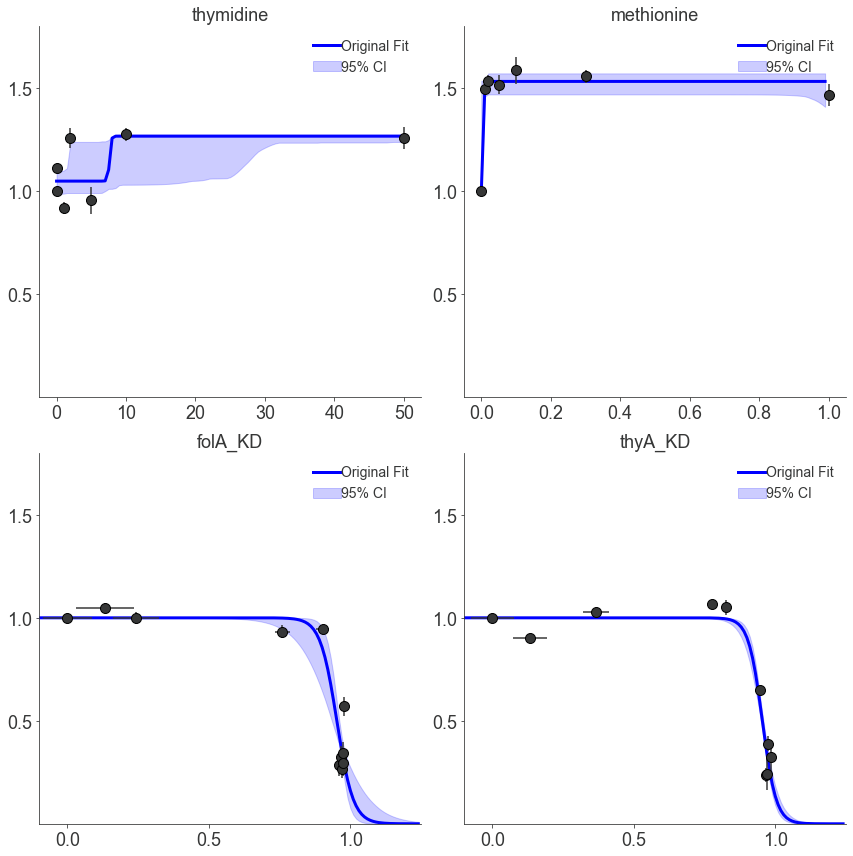

In [10]:
fitVal_list = {}
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for iterator, perturbation in enumerate(['thymidine', 'methionine', 'folA_KD', 'thyA_KD']):
    row, col = int(iterator/2), iterator%2
    if perturbation == 'thymidine':
        xVals = np.arange(0, 50, 0.5)
    elif perturbation == 'methionine':
        xVals = np.arange(0, 1, 0.01)
    elif perturbation in ['folA_KD', 'thyA_KD']:
        xVals = np.arange(-0.1, 1.25, 0.01)
        ax[row, col].set_xlim([-0.1, 1.25])
        ax[row, col].set_xticks([0, 0.5, 1])
    fitVal_list[perturbation] = []
    for boot_it in hill_est:
        if boot_it != 'Full Fit':
            fitVal_list[perturbation].append(growth_rate(xVals, hill_est[boot_it][perturbation])[0])
    low_q, high_q = [], []
    for i in range(len(fitVal_list[perturbation][0])):
        low_q.append(np.quantile([x[i] for x in fitVal_list[perturbation]], 0.025))
        high_q.append(np.quantile([x[i] for x in fitVal_list[perturbation]], 0.975)) 
    fitVals = growth_rate(xVals, hill_est['Full Fit'][perturbation])[0]
    ax[row, col].plot(xVals, fitVals, '-b', lw=3, label='Original Fit')
    ax[row, col].fill_between(xVals, low_q, high_q, alpha=0.2, color='b', label='95% CI')
    ax[row, col].legend()
    if perturbation in ['folA_KD', 'thyA_KD']:
        ax[row, col].errorbar(perturb_dict[perturbation], single_gr['Mean'][perturbation],
                              xerr=list(repression_sem_subset[perturbation].values()),
                              yerr=single_gr['Std'][perturbation], fmt='o', color='xkcd:dark gray', mec='k', ms=10)
    else:
        ax[row, col].errorbar(perturb_dict[perturbation], single_gr['Mean'][perturbation], 
                              yerr=[np.std(x) for x in env_growth_rate_reps['methionine'].values()], fmt='o',
                              color='xkcd:dark gray', mec='k', ms=10)
    ax[row, col].set_ylim([0, 1.8])
    ax[row, col].set_yticks([0.5, 1, 1.5])
    ax[row, col].set_title(perturbation, fontsize=18)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS8A-D.pdf')
plt.show()

### Fit coupling constants and calculate predicted growth rates

We fit coupling constants to pairwise perturbation-growth rate data, then use these coupling constants and single-gene sigmoid parameters to generate predicted growth rates for each perturbation combination -- up to fourth order. We also predict growth rates using a Null model without coupling, a multiplicative (Bliss) model that considers only perturbations directly investigated and cannot make continuous predictions, and a continuous epistasis model trained only on 20% of the pairwise growth rate measurements. Each model is fit using each of the 100 bootstrapped single-perturbation curves as well as our complete, not bootstrapped data set ("Full Fit"). As this code takes a reasonable amount of time to run, we've save it's output ahead of times. Most of these results are deterministic, however -- only the subsampled model's performance could change if this code block was re-run (the training data for the subsampled model is randomly generated every time this code runs).

In [11]:
"""
pair_avals, pair_avals_sub, pair_gr, pair_gr_sub, reg, sub = {}, {}, {}, {}, 10**-1.25, 0.8
pair_gr_all, _ = subsample(growth_rates_mean, 0)  # Train on pairwise data only
pair_gr['thymidine-methionine'] = pair_gr_all[:, :, 0, 0]
pair_gr['thymidine-folA_KD'] = pair_gr_all[:, 0, :, 0]
pair_gr['thymidine-thyA_KD'] = pair_gr_all[:, 0, 0, :]
pair_gr['methionine-folA_KD'] = pair_gr_all[0, :, :, 0]
pair_gr['methionine-thyA_KD'] = pair_gr_all[0, :, 0, :]
pair_gr['folA_KD-thyA_KD'] = pair_gr_all[0, 0, :, :]
for iterator in hill_est:
    pair_avals[iterator], pair_avals_sub[iterator] = {}, {}
    subsampled_gr, _ = subsample(growth_rates_mean, sub)
    pair_gr_sub['thymidine-methionine'] = subsampled_gr[:, :, 0, 0]
    pair_gr_sub['thymidine-folA_KD'] = subsampled_gr[:, 0, :, 0]
    pair_gr_sub['thymidine-thyA_KD'] = subsampled_gr[:, 0, 0, :]
    pair_gr_sub['methionine-folA_KD'] = subsampled_gr[0, :, :, 0]
    pair_gr_sub['methionine-thyA_KD'] = subsampled_gr[0, :, 0, :]
    pair_gr_sub['folA_KD-thyA_KD'] = subsampled_gr[0, 0, :, :]
    for perturb_pair in pair_gr_sub:
        if not sum([~np.isnan(x) for x in pair_gr_sub[perturb_pair].flatten()]):  # If all data was removed
            pair_gr_sub[perturb_pair][0, 0] = 1  # Put back in the wildtype measurement
    for (per1, per2) in itertools.combinations(perturb_list, 2):
        perturb_pair = f'{per1}-{per2}'
        pair_avals[iterator][perturb_pair] = least_squares(residuals_growthPairs, x0=[0, 0],
                bounds=[(-np.inf, -np.inf), (np.inf, np.inf)], args=(pair_gr[perturb_pair],
                hill_est[iterator][per1], hill_est[iterator][per2], perturb_dict[per1], perturb_dict[per2], reg)).x
        pair_avals_sub[iterator][perturb_pair] = least_squares(residuals_growthPairs, x0=[0, 0],
                bounds=[(-np.inf, -np.inf), (np.inf, np.inf)], args=(pair_gr_sub[perturb_pair],
                hill_est[iterator][per1], hill_est[iterator][per2], perturb_dict[per1], perturb_dict[per2], reg)).x
with open(f"{bootstrap_path}/{date}_env_pair_avals.pickle", 'wb') as handle:
    pickle.dump(pair_avals, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f"{bootstrap_path}/{date}_env_pair_avals_sub.pickle", 'wb') as handle:
    pickle.dump(pair_avals_sub, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

thymidine-thyA_KD coupling: 0.73


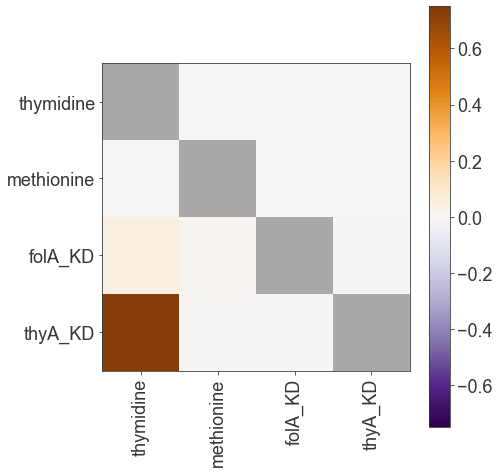

In [12]:
avals = np.full([len(perturb_list), len(perturb_list)], np.nan)
for i, per1 in enumerate(perturb_list):
    for j, per2 in enumerate(perturb_list[i+1:]):
        avals[i, j+i+1] = pair_avals['Full Fit'][f'{per1}-{per2}'][0]
        avals[j+i+1, i] = pair_avals['Full Fit'][f'{per1}-{per2}'][1]
print(f'thymidine-thyA_KD coupling: {np.round(pair_avals["Full Fit"]["thymidine-thyA_KD"][1], 3)}')
fig, ax = plt.subplots(figsize=(7, 7))
cb = ax.imshow(avals, cmap='PuOr_r', vmin=-0.75, vmax=0.75)
ax.set_yticks(np.arange(len(perturb_list)), labels=perturb_list)
ax.set_xticks(np.arange(len(perturb_list)), labels=perturb_list, rotation=90)
ax.set_facecolor("darkgrey")
ax.spines[['top', 'right']].set_visible(True)
plt.colorbar(cb)
plt.tight_layout()
plt.show()

### Predict all growth rates using models trained on single and pairwise growth rate data.

We use each model (all 100 bootstrap iterations and the "Full Fit") to predict bacterial growth rate for all possible combinations of the four perturbations investigated in this experiment. We calculate RMSD and AIC for each model based on these predictions. Our confidence interval on model performance comes from the central 95% of bootstrapped models.

In [13]:
gr_epistatic_pred = np.full(np.shape(growth_rates_mean)+(len(hill_est)-1,), np.nan)
gr_subsample_pred = np.full(np.shape(growth_rates_mean)+(len(hill_est)-1,), np.nan)
gr_null_pred = np.full(np.shape(growth_rates_mean)+(len(hill_est)-1,), np.nan)
null_RMSD, subsample_RMSD, epistatic_RMSD = [], [], []
null_AIC, subsample_AIC, epistatic_AIC = [], [], []
epi_k = 2*(len(hill_est['Full Fit'])) + 2*len(pair_avals['Full Fit'])
null_k = 2*(len(hill_est['Full Fit']))
for i in hill_est:
    if i != 'Full Fit':
        gr_epistatic_pred[:, :, :, :, i] = QuadGrowthRates(pair_avals[i], perturb_dict, hill_est[i])
        gr_subsample_pred[:, :, :, :, i] = QuadGrowthRates(pair_avals_sub[i], perturb_dict, hill_est[i])
        gr_null_pred[:, :, :, :, i] = QuadGrowthRates({perturb_pair:[0, 0] for perturb_pair in pair_avals[i]},
                                                      perturb_dict, hill_est[i])
        temp_epistatic_err = growth_rates_mean.flatten() - gr_epistatic_pred[:, :, :, :, i].flatten()
        temp_null_err = growth_rates_mean.flatten() - gr_null_pred[:, :, :, :, i].flatten()
        temp_subsample_err = growth_rates_mean.flatten() - gr_subsample_pred[:, :, :, :, i].flatten()
        epistatic_RMSD.append(nanrms(temp_epistatic_err))
        subsample_RMSD.append(nanrms(temp_subsample_err))
        null_RMSD.append(nanrms(temp_null_err))
        epistatic_AIC.append(2*epi_k + sum(~np.isnan(temp_epistatic_err)) \
                                     * np.log(np.nanmean([x**2 for x in temp_epistatic_err])))
        null_AIC.append(2*null_k + sum(~np.isnan(temp_null_err)) \
                                     * np.log(np.nanmean([x**2 for x in temp_null_err])))
        subsample_AIC.append(2*epi_k + sum(~np.isnan(temp_subsample_err)) \
                                     * np.log(np.nanmean([x**2 for x in temp_subsample_err])))
        
    else:
        full_gr_epistatic_pred = QuadGrowthRates(pair_avals[i], perturb_dict, hill_est[i])
        full_gr_null_pred = QuadGrowthRates({perturb_pair:[0, 0] for perturb_pair in pair_avals[i]},
                                             perturb_dict, hill_est[i])
        full_subsample_pred = QuadGrowthRates(pair_avals_sub[i], perturb_dict, hill_est[i])
        full_gr_epistatic_error = growth_rates_mean.flatten() - full_gr_epistatic_pred.flatten()
        full_gr_null_error = growth_rates_mean.flatten() - full_gr_null_pred.flatten()
        full_gr_subsample_error = growth_rates_mean.flatten() - full_subsample_pred.flatten()
        full_null_RMSD = nanrms(full_gr_null_error)
        full_epistatic_RMSD = nanrms(full_gr_epistatic_error)
        full_subsample_RMSD = nanrms(full_gr_subsample_error)
        full_epistatic_AIC = 2*epi_k + sum(~np.isnan(full_gr_epistatic_error)) \
                                     * np.log(np.nanmean([x**2 for x in full_gr_epistatic_error]))
        full_null_AIC = 2*null_k + sum(~np.isnan(full_gr_null_error)) \
                                     * np.log(np.nanmean([x**2 for x in full_gr_null_error]))
        full_subsample_AIC = 2*epi_k + sum(~np.isnan(full_gr_subsample_error)) \
                                     * np.log(np.nanmean([x**2 for x in full_gr_subsample_error]))
gr_epistatic_std = np.std(gr_epistatic_pred, axis=4)
gr_subsample_std = np.std(gr_subsample_pred, axis=4)
gr_null_std = np.std(gr_null_pred, axis=4)

In [14]:
for (title, full, data) in zip(['Epistatic', 'Subsampled', 'Null'],
                               [full_epistatic_RMSD, full_subsample_RMSD, full_null_RMSD],
                               [epistatic_RMSD, subsample_RMSD, null_RMSD]):
    print(f'{title} model RMSD, [95% CI]: '
          f'{np.round(full, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]')
print()
for (title, full, data) in zip(['Epistatic', 'Subsampled', 'Null'],
                               [full_epistatic_AIC, full_subsample_AIC, full_null_AIC],
                    [epistatic_AIC, subsample_AIC, null_AIC]):
    print(f'{title} model RMSD, [95% CI]: '
          f'{np.round(full, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]')

Epistatic model RMSD, [95% CI]: 0.26, [0.239, 0.33]
Subsampled model RMSD, [95% CI]: 0.282, [0.227, 0.386]
Null model RMSD, [95% CI]: 0.547, [0.521, 0.575]

Epistatic model RMSD, [95% CI]: -6415.637, [-6816.808, -5278.004]
Subsampled model RMSD, [95% CI]: -6019.889, [-7063.72, -4519.404]
Null model RMSD, [95% CI]: -2868.417, [-3107.883, -2636.855]


### Visualize important phenotypes in our data set

Our model, as currently constructed, outperforms the coupling insensitive Null model, but it doesn't accurately capture all phenotypes from our experimental data. Here we highlight where the continuous epistasis model outperforms the Null model as well as where error in our model's predictions arises.

Our model accounts for the obvious coupling seen between $thyA$ knockdown (columns) and thymidine supplementation (bottom row of heat maps). Following thymidine supplementation, $thyA$ sgRNAs have no effect on growth rate (when $folA$ is not perturbed -- more on that later), and our continuous epistasis model captures this positive coupling to reproduce the phenotype.

Interestingly, when thymidine is added AND $folA$ is repressed by an sgRNA, $thyA$ sgRNAs have a beneficial effect on growth. This third-order coupling recapitulates prior data, but is not captured by our model or the Null model.

Thus, we conclude that when our model outperforms the Null model, it is likely due to pairwise coupling. However, if the model fails in a systematic way (i.e. not obviously due to variation in input data, etc.), it could be indicative of an additional interaction between perturbations -- in this case a high-order epistatic interaction.

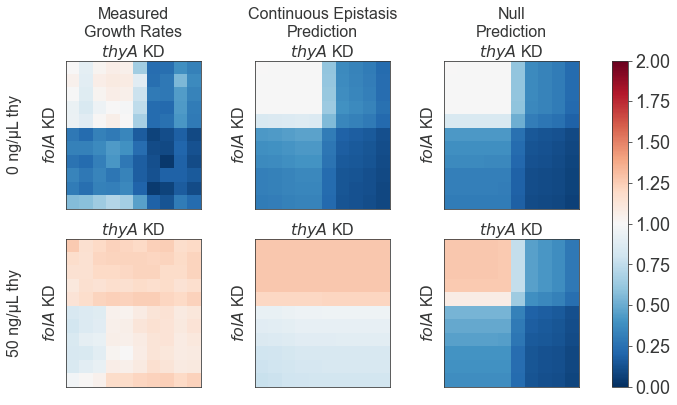

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
cb = ax[0, 0].imshow(growth_rates_mean[0, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[1, 0].imshow(growth_rates_mean[-1, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[0, 1].imshow(full_gr_epistatic_pred[0, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[1, 1].imshow(full_gr_epistatic_pred[-1, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[0, 2].imshow(full_gr_null_pred[0, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[1, 2].imshow(full_gr_null_pred[-1, 0, :, :], cmap='RdBu_r', vmin=0, vmax=2)
ax[0, 0].set_title('Measured\nGrowth Rates', fontsize=16)
ax[0, 1].set_title('Continuous Epistasis\nPrediction', fontsize=16)
ax[0, 2].set_title('Null\nPrediction', fontsize=16)
for row in range(2):
    for col in range(3):
        ax[row, col].spines[['top', 'right']].set_visible(True)
        ax[row, col].set_xticks([])
        ax[row, col].xaxis.set_label_position('top')
        ax[row, col].set_yticks([])
        ax[row, col].set_xlabel('${thyA}$ KD', fontsize=16)
        if row == 0 and col == 0:
            ax[row, col].set_ylabel('0 ng/μL thy\n\n${folA}$ KD', fontsize=16)
        elif row == 1 and col == 0: 
            ax[row, col].set_ylabel('50 ng/μL thy\n\n${folA}$ KD', fontsize=16)
        else:
            ax[row, col].set_ylabel('${folA}$ KD', fontsize=16)
plt.colorbar(cb, ax=ax.ravel().tolist())
plt.savefig(f'{figure_path}/Fig7E.pdf')
plt.show()

### Pull out second-order perturbation data and high-order (third and fourth) perturbation data

As our model is trained on pairwise data, it makes sense that it would perform well (and outperform the Null model) when evaluated on those pairwise measurements. Its ability to generalize and predict higher-order combinations of perturbations is another question, so we separate our data by perturbation order and independently evaluate each model's RMSD.

In [16]:
true_2nd_order_gr, true_high_order_gr = extract_data(growth_rates_mean)
_, true_high_order_std = extract_data(growth_rates_std)
full_epi_2nd_order_gr, full_epi_high_order_gr = extract_data(full_gr_epistatic_pred)
_, full_epi_high_order_std = extract_data(gr_epistatic_std)
full_null_2nd_order_gr, full_null_high_order_gr = extract_data(full_gr_null_pred)
full_sub_2nd_order_gr, full_sub_high_order_gr = extract_data(full_subsample_pred)
_, full_sub_high_order_std = extract_data(gr_subsample_std)
full_epistatic_2nd_order_RMSD = nanrms(true_2nd_order_gr - full_epi_2nd_order_gr)
full_epistatic_high_order_RMSD = nanrms(true_high_order_gr - full_epi_high_order_gr)
full_null_2nd_order_RMSD = nanrms(true_2nd_order_gr - full_null_2nd_order_gr)
full_null_high_order_RMSD = nanrms(true_high_order_gr - full_null_high_order_gr)
full_sub_2nd_order_RMSD = nanrms(true_2nd_order_gr - full_sub_2nd_order_gr)
full_sub_high_order_RMSD = nanrms(true_high_order_gr - full_sub_high_order_gr)
epistatic_2nd_order_pred, epistatic_high_order_pred = [], []
null_2nd_order_pred, null_high_order_pred = [], []
sub_2nd_order_pred, sub_high_order_pred = [], []
epistatic_2nd_order_RMSD, epistatic_high_order_RMSD = [], []
null_2nd_order_RMSD, null_high_order_RMSD = [], []
sub_2nd_order_RMSD, sub_high_order_RMSD = [], []
for i in hill_est:
    if i != 'Full Fit':
        temp_epi_2nd, temp_epi_high = extract_data(gr_epistatic_pred[:, :, :, :, i])
        epistatic_2nd_order_pred.append(temp_epi_2nd)
        epistatic_high_order_pred.append(temp_epi_high)
        temp_null_2nd, temp_null_high = extract_data(gr_null_pred[:, :, :, :, i])
        null_2nd_order_pred.append(temp_null_2nd)
        null_high_order_pred.append(temp_null_high)
        temp_sub_2nd, temp_sub_high = extract_data(gr_subsample_pred[:, :, :, :, i])
        sub_2nd_order_pred.append(temp_sub_2nd)
        sub_high_order_pred.append(temp_sub_high)
        epistatic_2nd_order_RMSD.append(nanrms(epistatic_2nd_order_pred[i] - true_2nd_order_gr))
        epistatic_high_order_RMSD.append(nanrms(epistatic_high_order_pred[i] - true_high_order_gr))
        null_2nd_order_RMSD.append(nanrms(null_2nd_order_pred[i] - true_2nd_order_gr))
        null_high_order_RMSD.append(nanrms(null_high_order_pred[i] - true_high_order_gr))
        sub_2nd_order_RMSD.append(nanrms(sub_2nd_order_pred[i] - true_2nd_order_gr))
        sub_high_order_RMSD.append(nanrms(sub_high_order_pred[i] - true_high_order_gr))

### Alternate model predictions

The continuous epistasis and Null models are not the only models to estimate high-order phenotypes from low-order data. Here we investigate how our model compares to less interpretable (but often accurate) alternative models, a regression-based model and the Isserlis model. As the base implementations of these models are not continuous, we modified each alternative model as in Zimmer et al., 2016 by using the continuous and generalizable first- and second-order growth rates generated and used by the continuous epistasis model to predict high-order phenotypes. Our model has performance equivalent to these alternative models, but it is (i) inherently continuous and (ii) interpretable -- we report coupling constants with meaningful signs, magnitudes, and asymmetries that are absent in these alternate epistasis models. We also calculate a not continuous multiplicative Bliss prediction.

In [17]:
bliss_quad_gr = np.full(np.shape(growth_rates_mean), np.nan)
isserlis_quad_gr = np.full(np.shape(growth_rates_mean), np.nan)
regression_quad_gr = np.full(np.shape(growth_rates_mean), np.nan)
bliss_quad_std = np.full(np.shape(growth_rates_mean), np.nan)
isserlis_quad_std = np.full(np.shape(growth_rates_mean), np.nan)
regression_quad_std = np.full(np.shape(growth_rates_mean), np.nan)
for i, (true_gr1, true_std1, gr1, std1) in enumerate(zip(growth_rates_mean[:, 0, 0, 0],
                                                         growth_rates_std[:, 0, 0, 0],
                                                         full_gr_epistatic_pred[:, 0, 0, 0],
                                                         gr_epistatic_std[:, 0, 0, 0])):
    for j, (true_gr2, true_std2, gr2, std2) in enumerate(zip(growth_rates_mean[0, :, 0, 0],
                                                             growth_rates_std[0, :, 0, 0],
                                                             full_gr_epistatic_pred[0, :, 0, 0],
                                                             gr_epistatic_std[0, :, 0, 0])):
        for k, (true_gr3, true_std3, gr3, std3) in enumerate(zip(growth_rates_mean[0, 0, :, 0],
                                                                 growth_rates_std[0, 0, :, 0],
                                                                 full_gr_epistatic_pred[0, 0, :, 0],
                                                                 gr_epistatic_std[0, 0, :, 0])):
            for l, (true_gr4, true_std4, gr4, std4) in enumerate(zip(growth_rates_mean[0, 0, 0, :],
                                                                     growth_rates_std[0, 0, 0, :],
                                                                     full_gr_epistatic_pred[0, 0, 0, :],
                                                                     gr_epistatic_std[0, 0, 0, :])):
                if ~np.isnan(growth_rates_mean[i, j, k, l]):
                    bliss_quad_gr[i, j, k, l] = true_gr1 * true_gr2 * true_gr3 * true_gr4
                    bliss_quad_std[i, j, k, l] = bliss_quad_gr[i, j, k, l] \
                                               * np.sqrt((true_std1/true_gr1)**2 + (true_std2/true_gr2)**2
                                                       + (true_std3/true_gr3)**2
                                                       + (true_std4/true_gr4)**2)
                    if sum([idx == 0 for idx in [i, j, k, l]]) == 1:  # Third order perturbation
                        if i == 0:
                            new_gr1, new_gr2, new_gr3 = gr2, gr3, gr4
                            new_std1, new_std2, new_std3 = std2, std3, std4
                            gr12, std12 = full_gr_epistatic_pred[0, j, k, 0], gr_epistatic_std[0, j, k, 0]
                            gr13, std13 = full_gr_epistatic_pred[0, j, 0, l], gr_epistatic_std[0, j, 0, l]
                            gr23, std23 = full_gr_epistatic_pred[0, 0, k, l], gr_epistatic_std[0, 0, k, l]
                        elif j == 0:
                            new_gr1, new_gr2, new_gr3 = gr1, gr3, gr4
                            new_std1, new_std2, new_std3 = std1, std3, std4
                            gr12, std12 = full_gr_epistatic_pred[i, 0, k, 0], gr_epistatic_std[i, 0, k, 0]
                            gr13, std13 = full_gr_epistatic_pred[i, 0, 0, l], gr_epistatic_std[i, 0, 0, l]
                            gr23, std23 = full_gr_epistatic_pred[0, 0, k, l], gr_epistatic_std[0, 0, k, l]
                        elif k == 0:
                            new_gr1, new_gr2, new_gr3 = gr1, gr2, gr4
                            new_std1, new_std2, new_std3 = std1, std2, std4
                            gr12, std12 = full_gr_epistatic_pred[i, j, 0, 0], gr_epistatic_std[i, j, 0, 0]
                            gr13, std13 = full_gr_epistatic_pred[i, 0, 0, l], gr_epistatic_std[i, 0, 0, l]
                            gr23, std23 = full_gr_epistatic_pred[0, j, 0, l], gr_epistatic_std[0, j, 0, l]
                        else:
                            new_gr1, new_gr2, new_gr3 = gr1, gr2, gr3
                            new_std1, new_std2, new_std3 = std1, std2, std3
                            gr12, std12 = full_gr_epistatic_pred[i, j, 0, 0], gr_epistatic_std[i, j, 0, 0]
                            gr13, std13 = full_gr_epistatic_pred[i, 0, k, 0], gr_epistatic_std[i, 0, k, 0]
                            gr23, std23 = full_gr_epistatic_pred[0, j, k, 0], gr_epistatic_std[0, j, k, 0]
                        isserlis_quad_gr[i, j, k, l] = gr12*new_gr3 + gr13*new_gr2 + gr23*new_gr1 \
                                                     - 2*new_gr1*new_gr2*new_gr3
                        # Error propagation through partial derivation of the original formula
                        isserlis_quad_std[i, j, k, l] = np.sqrt(new_std1**2*(gr23-2*new_gr2*new_gr3)**2 \
                                                              + new_std2**2*(gr13-2*new_gr1*new_gr3)**2 \
                                                              + new_std3**2*(gr12-2*new_gr1*new_gr2)**2 \
                                                              + std12**2*new_gr3**2 + std13**2*new_gr2**2 \
                                                              + std23**2*new_gr1**2)
                        regression_quad_gr[i, j, k, l] = gr12 * gr13 * gr23 / (new_gr1*new_gr2*new_gr3)
                        # Error propagation through partial derivation of the original formula
                        regression_quad_std[i, j, k, l] = regression_quad_gr[i, j, k, l] \
                                                        * np.sqrt((std12/gr12)**2 + (std13/gr13)**2 + (std23/gr23)**2
                                                                + (-new_std1/new_gr1)**2 + (-new_std2/new_gr2)**2
                                                                + (-new_std3/new_gr3)**2)
                    elif sum([idx == 0 for idx in [i, j, k, l]]) == 0:  # Fourth order perturbation
                        gr12, std12 = full_gr_epistatic_pred[i, j, 0, 0], gr_epistatic_std[i, j, 0, 0]
                        gr13, std13 = full_gr_epistatic_pred[i, 0, k, 0], gr_epistatic_std[i, 0, k, 0]
                        gr14, std14 = full_gr_epistatic_pred[i, 0, 0, l], gr_epistatic_std[i, 0, 0, l]
                        gr23, std23 = full_gr_epistatic_pred[0, j, k, 0], gr_epistatic_std[0, j, k, 0]
                        gr24, std24 = full_gr_epistatic_pred[0, j, 0, l], gr_epistatic_std[0, j, 0, l]
                        gr34, std34 = full_gr_epistatic_pred[0, 0, k, l], gr_epistatic_std[0, 0, k, l]
                        isserlis_quad_gr[i, j, k, l] = gr12*gr34 + gr13*gr24 + gr14*gr23 - 2*gr1*gr2*gr3*gr4
                        # Error propagation through partial derivation of the original formula
                        isserlis_quad_std[i, j, k, l] = np.sqrt(std1**2*(-2*gr2*gr3*gr4)**2 \
                                                              + std2**2*(-2*gr1*gr3*gr4)**2 \
                                                              + std3**2*(-2*gr1*gr2*gr4)**2 \
                                                              + std4**2*(-2*gr1*gr2*gr3)**2 \
                                                              + std12**2*gr34**2 + std13**2*gr24**2 \
                                                              + std14**2*gr23**2 + std23**2*gr14**2 \
                                                              + std24**2*gr13**2 + std34**2*gr12**2)
                        regression_quad_gr[i, j, k, l] = gr12*gr13*gr14*gr23*gr24*gr34 / (gr1*gr2*gr3*gr4)**2
                        # Error propagation through partial derivation of the original formula
                        regression_quad_std[i, j, k, l] = regression_quad_gr[i, j, k, l] \
                                                        * np.sqrt((std12/gr12)**2 + (std13/gr13)**2 + (std14/gr14)**2
                                                                + (std23/gr23)**2 + (std24/gr24)**2 + (std34/gr34)**2
                                                                + (-2*std1/gr1)**2 + (-2*std2/gr2)**2 
                                                                + (-2*std3/gr3)**2 + (-2*std4/gr4)**2)
# These models are meant to predict high-order phenotypes, not pairwise ones
_, isserlis_high_order_gr = extract_data(isserlis_quad_gr)
_, isserlis_high_order_std = extract_data(isserlis_quad_std)
_, regression_high_order_gr = extract_data(regression_quad_gr)
_, regression_high_order_std = extract_data(regression_quad_std)
bliss_RMSD = nanrms(growth_rates_mean.flatten() - bliss_quad_gr.flatten())
isserlis_RMSD = np.round(nanrms(isserlis_high_order_gr - true_high_order_gr), 3)
regression_RMSD = np.round(nanrms(regression_high_order_gr - true_high_order_gr), 3)

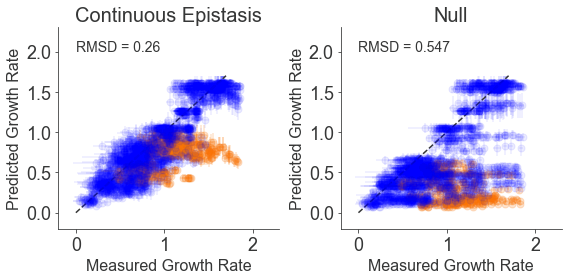

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, [model, mean, err, RMSD] in enumerate(zip(['Continuous Epistasis', 'Null'],
                                                 [full_gr_epistatic_pred, full_gr_null_pred],
                                                 [gr_epistatic_std, gr_null_std],
                                                 [full_epistatic_RMSD, full_null_RMSD])):
    # Isolate likely third-order effects from remaining data
    model_gr_copy, model_std_copy = mean.copy(), err.copy()
    model_gr_copy[2:, :, 6:, 3:], model_std_copy[2:, :, 6:, 3:] = np.nan, np.nan
    measured_gr_copy, measured_std_copy = growth_rates_mean.copy(), growth_rates_std.copy()
    measured_gr_copy[2:, :, 6:, 3:], measured_std_copy[2:, :, 6:, 3:] = np.nan, np.nan
    ax[i].errorbar(growth_rates_mean[2:, :, 6:, 3:].flatten(), mean[2:, :, 6:, 3:].flatten(),
                   xerr=growth_rates_std[2:, :, 6:, 3:].flatten(), yerr=err[2:, :, 6:, 3:].flatten(), fmt='o',
                   color='xkcd:orange', ms=7, alpha=0.2)
    ax[i].errorbar(measured_gr_copy.flatten(), model_gr_copy.flatten(), xerr=measured_std_copy.flatten(), 
               yerr=model_std_copy.flatten(), fmt='o', color='b', ms=7, alpha=0.08)
    ax[i].text(0, 2, f'RMSD = {np.round(RMSD, 3)}', fontsize=14)
    ax[i].set_title(model, fontsize=20)
    ax[i].plot([0, 1.7], [0, 1.7], color='xkcd:dark gray', ls='--')
    ax[i].set_xlabel('Measured Growth Rate', fontsize=16)
    ax[i].set_ylabel('Predicted Growth Rate', fontsize=16)
    ax[i].set_xlim([-0.2, 2.3])
    ax[i].set_ylim([-0.2, 2.3])
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig7C-D.pdf')
plt.show()

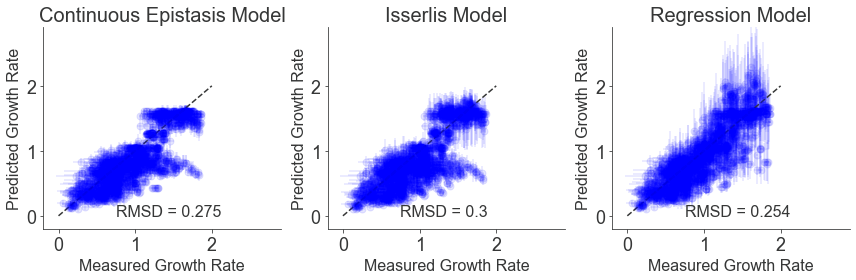

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, [model, mean, err, RMSD] in enumerate(zip(['Continuous Epistasis', 'Isserlis', 'Regression'],
                                        [full_epi_high_order_gr, isserlis_high_order_gr, regression_high_order_gr],
                                        [full_epi_high_order_std, isserlis_high_order_std, regression_high_order_std],
                                        [full_epistatic_high_order_RMSD, isserlis_RMSD, regression_RMSD])):
    ax[i].errorbar(true_high_order_gr.flatten(), mean.flatten(), xerr=true_high_order_std.flatten(),
               yerr=err.flatten(), fmt='o', color='b', ms=7, alpha=0.1)
    ax[i].text(0.75, 0, f'RMSD = {np.round(RMSD, 3)}', fontsize=16)
    ax[i].set_title(f'{model} Model', fontsize=20)
    ax[i].plot([0, 2], [0, 2], color='xkcd:dark gray', ls='--')
    ax[i].set_xlabel('Measured Growth Rate', fontsize=16)
    ax[i].set_ylabel('Predicted Growth Rate', fontsize=16)
    ax[i].set_xlim([-0.2, 2.9])
    ax[i].set_ylim([-0.2, 2.9])
plt.tight_layout()
plt.show()

In [20]:
for (title, RMSD, data) in zip(['Epi 2nd', 'Null 2nd', 'Subsampled 2nd', 'Epi High', 'Null High', 'Subsampled High'],
                    [full_epistatic_2nd_order_RMSD, full_null_2nd_order_RMSD, full_sub_2nd_order_RMSD, 
                     full_epistatic_high_order_RMSD, full_null_high_order_RMSD, full_sub_high_order_RMSD],
                    [epistatic_2nd_order_RMSD, null_2nd_order_RMSD, sub_2nd_order_RMSD, epistatic_high_order_RMSD,
                     null_high_order_RMSD, sub_high_order_RMSD]):
    print(f'{title} model RMSD, [95% CI]: '
          f'{np.round(RMSD, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]')

Epi 2nd model RMSD, [95% CI]: 0.145, [0.144, 0.176]
Null 2nd model RMSD, [95% CI]: 0.273, [0.26, 0.293]
Subsampled 2nd model RMSD, [95% CI]: 0.151, [0.147, 0.194]
Epi High model RMSD, [95% CI]: 0.275, [0.252, 0.351]
Null High model RMSD, [95% CI]: 0.584, [0.555, 0.612]
Subsampled High model RMSD, [95% CI]: 0.3, [0.237, 0.412]


### Calculate and visualize prediction error within different perturbation regimes.

Finally, we visualize the continuous epistasis and Null models' errors after separating their predictions by perturbation. We see that (as expected) the continuous epistasis model outperforms the Null model the most for perturbation sets with thymidine supplementation and $thyA$ knockdown (our strongest epistatic pair). Thymidine supplementation and $folA$ knockdown have a lesser, but still obvious effect, and these improvements over the Null model hold even as additional perturbations compound. 

In [21]:
rmsd_dict = {'Epistatic':{}, 'Null':{}, 'Subsampled':{}}
for model, data, full in zip(rmsd_dict, [gr_epistatic_pred, gr_null_pred, gr_subsample_pred],
                             [full_gr_epistatic_pred, full_gr_null_pred, full_subsample_pred]):
    for i in hill_est:
        rmsd_dict[model][i] = {}
        if i != 'Full Fit':
            rmsd_dict[model][i]['thymidine-methionine'] = nanrms(data[1:, 1:, 0, 0, i].flatten()
                                                               - growth_rates_mean[1:, 1:, 0, 0].flatten())
            rmsd_dict[model][i]['thymidine-folA_KD'] = nanrms(data[1:, 0, 1:, 0, i].flatten()
                                                            - growth_rates_mean[1:, 0, 1:, 0].flatten())
            rmsd_dict[model][i]['thymidine-thyA_KD'] = nanrms(data[1:, 0, 0, 1:, i].flatten()
                                                            - growth_rates_mean[1:, 0, 0, 1:].flatten())
            rmsd_dict[model][i]['methionine-folA_KD'] = nanrms(data[0, 1:, 1:, 0, i].flatten()
                                                             - growth_rates_mean[0, 1:, 1:, 0].flatten())
            rmsd_dict[model][i]['methionine-thyA_KD'] = nanrms(data[0, 1:, 0, 1:, i].flatten()
                                                             - growth_rates_mean[0, 1:, 0, 1:].flatten())
            rmsd_dict[model][i]['folA_KD-thyA_KD'] = nanrms(data[0, 0, 1:, 1:, i].flatten()
                                                          - growth_rates_mean[0, 0, 1:, 1:].flatten())
            rmsd_dict[model][i]['thymidine-methionine-folA_KD'] = nanrms(data[1:, 1:, 1:, 0, i].flatten()
                                                                       - growth_rates_mean[1:, 1:, 1:, 0].flatten())
            rmsd_dict[model][i]['thymidine-methionine-thyA_KD'] = nanrms(data[1:, 1:, 0, 1:, i].flatten()
                                                                       - growth_rates_mean[1:, 1:, 0, 1:].flatten())
            rmsd_dict[model][i]['thymidine-folA_KD-thyA_KD'] = nanrms(data[1:, 0, 1:, 1:, i].flatten()
                                                                    - growth_rates_mean[1:, 0, 1:, 1:].flatten())
            rmsd_dict[model][i]['methionine-folA_KD-thyA_KD'] = nanrms(data[0, 1:, 1:, 1:, i].flatten()
                                                                     - growth_rates_mean[0, 1:, 1:, 1:].flatten())
            rmsd_dict[model][i]['thymidine-methionine-folA_KD-thyA_KD'] = nanrms(data[1:, 1:, 1:, 1:, i].flatten()
                                                                        - growth_rates_mean[1:, 1:, 1:, 1:].flatten())
        else:
            rmsd_dict[model]['Full Fit']['thymidine-methionine'] = nanrms(full[1:, 1:, 0, 0].flatten()
                                                                        - growth_rates_mean[1:, 1:, 0, 0].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-folA_KD'] = nanrms(full[1:, 0, 1:, 0].flatten()
                                                                     - growth_rates_mean[1:, 0, 1:, 0].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-thyA_KD'] = nanrms(full[1:, 0, 0, 1:].flatten()
                                                                     - growth_rates_mean[1:, 0, 0, 1:].flatten())
            rmsd_dict[model]['Full Fit']['methionine-folA_KD'] = nanrms(full[0, 1:, 1:, 0].flatten()
                                                                      - growth_rates_mean[0, 1:, 1:, 0].flatten())
            rmsd_dict[model]['Full Fit']['methionine-thyA_KD'] = nanrms(full[0, 1:, 0, 1:].flatten()
                                                                      - growth_rates_mean[0, 1:, 0, 1:].flatten())
            rmsd_dict[model]['Full Fit']['folA_KD-thyA_KD'] = nanrms(full[0, 0, 1:, 1:].flatten()
                                                                   - growth_rates_mean[0, 0, 1:, 1:].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-methionine-folA_KD'] = nanrms(full[1:, 1:, 1:, 0].flatten()
                                                                         - growth_rates_mean[1:, 1:, 1:, 0].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-methionine-thyA_KD'] = nanrms(full[1:, 1:, 0, 1:].flatten()
                                                                         - growth_rates_mean[1:, 1:, 0, 1:].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-folA_KD-thyA_KD'] = nanrms(full[1:, 0, 1:, 1:].flatten()
                                                                         - growth_rates_mean[1:, 0, 1:, 1:].flatten())
            rmsd_dict[model]['Full Fit']['methionine-folA_KD-thyA_KD'] = nanrms(full[0, 1:, 1:, 1:].flatten()
                                                                         - growth_rates_mean[0, 1:, 1:, 1:].flatten())
            rmsd_dict[model]['Full Fit']['thymidine-methionine-folA_KD-thyA_KD'] = \
                                                                   nanrms(full[1:, 1:, 1:, 1:].flatten()
                                                                        - growth_rates_mean[1:, 1:, 1:, 1:].flatten())

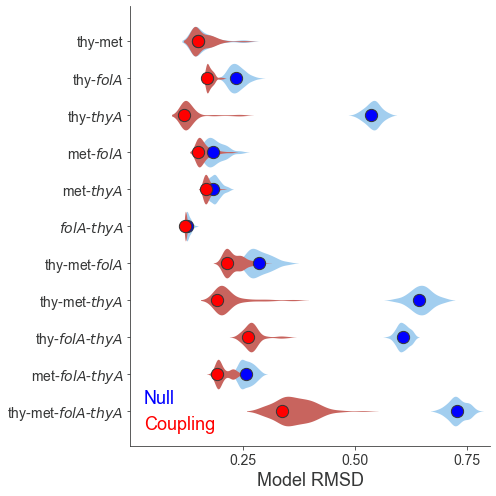

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
x = np.array([[rmsd_dict['Null'][i][params] for params in rmsd_dict['Null']['Full Fit']] for i in 
               rmsd_dict['Null'] if i != 'Full Fit'])
sns.violinplot(data=x, color='xkcd:light blue', orient='h', linewidth=0, scale='width')
y = np.array([[rmsd_dict['Epistatic'][i][params] for params in rmsd_dict['Epistatic']['Full Fit']] for i in 
             rmsd_dict['Epistatic'] if i != 'Full Fit'])
sns.violinplot(data=y, color='xkcd:pale red', orient='h', linewidth=0, scale='width')
for i, params in enumerate(list(rmsd_dict['Null']['Full Fit'].keys())):
    ax.scatter(rmsd_dict['Null']['Full Fit'][params], i, color='b', s=150, ec='xkcd:dark gray')
    ax.scatter(rmsd_dict['Epistatic']['Full Fit'][params], i, color='r', s=150, ec='xkcd:dark gray')
ax.tick_params(axis='both', labelsize=14)
ax.set_yticks(range(len(list(rmsd_dict['Epistatic']['Full Fit'].values()))))
ax.set_yticklabels(['thy-met', 'thy-$folA$', 'thy-$thyA$', 'met-$folA$', 'met-$thyA$', '$folA$-$thyA$',
                    'thy-met-$folA$', 'thy-met-$thyA$', 'thy-$folA$-$thyA$', 'met-$folA$-$thyA$',
                    'thy-met-$folA$-$thyA$'])
ax.set_xticks([0.25, 0.5, 0.75])
ax.set_xlabel('Model RMSD', fontsize=18)
ax.set_xlim([0, 0.8])
ax.text(0.03, 10.5, 'Coupling', color='r', fontsize=18)
ax.text(0.03, 9.8, 'Null', color='b', fontsize=18)
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig7F.pdf')
plt.show()

### Effects of regularization and subsampling on the model.

We investigated the effects of changing subsampling and regularization parameters by repeating the subsampling procedure 100 times with many different internal parameters. This code should be run on a computing cluster if it is to be repeated. We have saved the output of our repeated iterations, and summarize results below. Model sensitivity was comparable to the model iteration trained on pairwise CRISPRi data, so we used the same subsampling and regularization parameters.

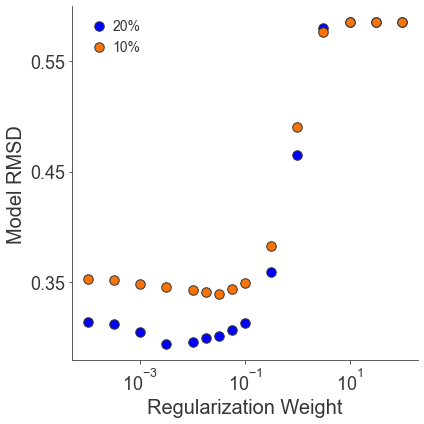

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
for i, sub in enumerate(regularization_rmsd):
    if sub == 0.8:
        ax.scatter(list(regularization_rmsd[sub].keys()), [np.mean(x) for x in regularization_rmsd[sub].values()],
                   s=90, color=['b', 'xkcd:orange'][i], edgecolor='xkcd:dark gray', label='20%')
    elif sub == 0.9:
        ax.scatter(list(regularization_rmsd[sub].keys()), [np.mean(x) for x in regularization_rmsd[sub].values()],
                   s=90, color=['b', 'xkcd:orange'][i], edgecolor='xkcd:dark gray', label='10%')
ax.set_xscale('log')
ax.set_xlabel('Regularization Weight', fontsize=20)
ax.set_ylabel('Model RMSD', fontsize=20)
ax.set_yticks([0.35, 0.45, 0.55])
ax.tick_params(axis='both', labelsize=18)
ax.legend()
plt.tight_layout()
plt.show()

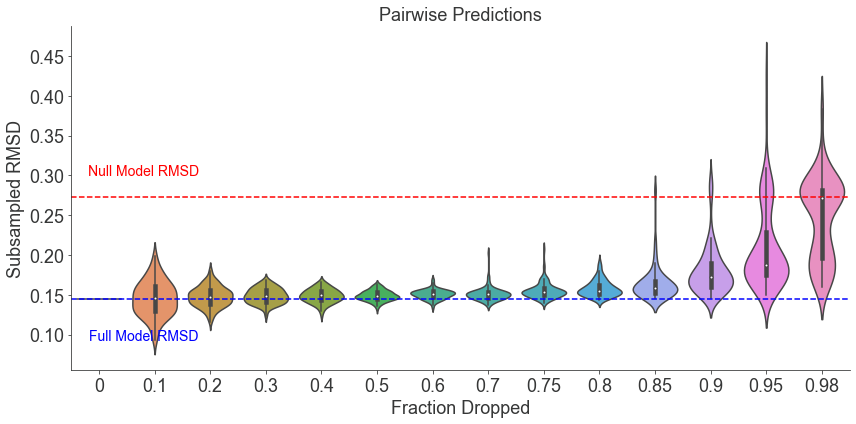

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
RMSD_labels = list(subsampling_rmsd.keys())
RMSD_toPlot = list(np.array(subsampling_rmsd[sub]['pair']) for sub in RMSD_labels)
sns.violinplot(data=RMSD_toPlot, scale = 'width')
ax.set_xticklabels(RMSD_labels)
ax.axhline(full_null_2nd_order_RMSD, ls='--', color='r')
ax.axhline(full_epistatic_2nd_order_RMSD, ls='--', color='b')
ax.set_ylabel('Subsampled RMSD', fontsize=18)
ax.set_xlabel('Fraction Dropped', fontsize=18)
ax.set_title('Pairwise Predictions', fontsize=18)
plt.text(0.8, 0.093, "Full Model RMSD", horizontalalignment='center', fontsize=14, color='b')
plt.text(0.8, 0.3, "Null Model RMSD", horizontalalignment='center', fontsize=14, color='r')
plt.tight_layout()
plt.show()

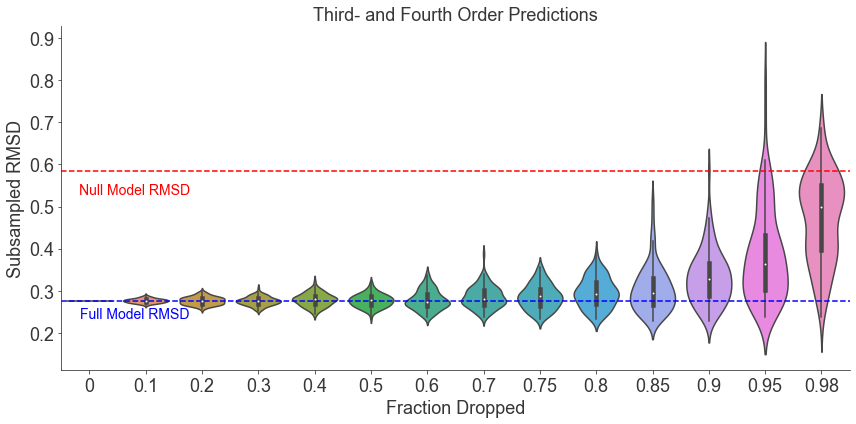

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
RMSD_labels = list(subsampling_rmsd.keys())
RMSD_toPlot = list(np.array(subsampling_rmsd[sub]['high']) for sub in RMSD_labels)
sns.violinplot(data=RMSD_toPlot, scale='width')
ax.set_xticklabels(RMSD_labels)
ax.axhline(full_null_high_order_RMSD, ls='--', color='r')
ax.axhline(full_epistatic_high_order_RMSD, ls='--', color='b')
ax.set_ylabel('Subsampled RMSD', fontsize=18)
ax.set_xlabel('Fraction Dropped', fontsize=18)
ax.set_title('Third- and Fourth Order Predictions', fontsize=18)
plt.text(0.8, 0.235, "Full Model RMSD", horizontalalignment='center', fontsize=14, color='b')
plt.text(0.8, 0.53, "Null Model RMSD", horizontalalignment='center', fontsize=14, color='r')
plt.tight_layout()
plt.show()

### The following code should (probably) not be run locally.

In [26]:
"""
num_its, sub_list, reg_list = 100, [0.8, 0.9], [10**-4, 10**-3.5, 10**-3, 10**-2.5, 10**-2, 10**-1.75, 10**-1.5,
                                                10**-1.25, 10**-1, 10**-0.5, 10**0, 10**0.5, 10**1, 10**1.5, 10**2]
reg_rmsd_store = {}
for sub in sub_list:
    reg_rmsd_store[sub] = {reg:[] for reg in reg_list}
    print(f'Subsampling: {sub}')
    for i in range(num_its):
        print(f'Iteration {i+1}, ', end='')
        reg_training, reg_test = subsample(growth_rates_mean, sub)
        reg_gr = {}
        reg_gr['thymidine-methionine'] = [reg_training[:, :, 0, 0], reg_test[:, :, 0, 0]]
        reg_gr['thymidine-folA_KD'] = [reg_training[:, 0, :, 0], reg_test[:, 0, :, 0]]
        reg_gr['thymidine-thyA_KD'] = [reg_training[:, 0, 0, :], reg_test[:, 0, 0, :]]
        reg_gr['methionine-folA_KD'] = [reg_training[0, :, :, 0], reg_test[0, :, :, 0]]
        reg_gr['methionine-thyA_KD'] = [reg_training[0, :, 0, :], reg_test[0, :, 0, :]]
        reg_gr['folA_KD-thyA_KD'] = [reg_training[0, 0, :, :], reg_test[0, 0, :, :]]
        for perturb_pair in reg_gr:
            if not sum([~np.isnan(x) for x in reg_gr[perturb_pair][0].flatten()]):
                reg_gr[perturb_pair][0][0, 0] = 1
        for reg in reg_list:
            pair_avals_reg = {}
            for (per1, per2) in itertools.combinations(perturb_list, 2):
                perturb_pair = f'{per1}-{per2}'
                pair_avals_reg[perturb_pair] = least_squares(residuals_growthPairs, x0=[0, 0],
                                                    bounds=[(-np.inf, -np.inf), (np.inf, np.inf)],
                                                    args=(reg_gr[perturb_pair][0], hill_est[i][per1],
                                                    hill_est[i][per2], perturb_dict[per1], perturb_dict[per2], reg)).x
            reg_gr_epistatic_pred = QuadGrowthRates(pair_avals_reg, perturb_dict, hill_est[i])
            reg_epistatic_high_order_pred = np.concatenate((reg_gr_epistatic_pred[1:, 1:, 1:, 0].flatten(),
                                             reg_gr_epistatic_pred[1:, 0, 1:, 1:].flatten(),
                                            reg_gr_epistatic_pred[1:, 1:, 0, 1:].flatten(),
                                            reg_gr_epistatic_pred[0, 1:, 1:, 1:].flatten(),
                                       reg_gr_epistatic_pred[1:, 1:, 1:, 1:].flatten()))
            reg_rmsd_store[sub][reg].append(nanrms(reg_epistatic_high_order_pred - true_high_order_gr))
with open(f"{optimization_path}/{date}_reg_opt_rmsd.pickle", 'wb') as handle:
    pickle.dump(reg_rmsd_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

In [27]:
"""
num_its, reg, sub_list = 100, 10**-1.25, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]
sub_rmsd_store = {}
for sub in sub_list:
    sub_rmsd_store[sub] = {'pair':[], 'high':[]}
    print(f'Subsampling: {sub}')
    for i in range(num_its):
        if (i+1) % 10 == 0:
            print(f'Iteration {i+1}, ', end='')
        sub_training, sub_test = subsample(growth_rates_mean, sub)
        sub_gr = {}
        sub_gr['thymidine-methionine'] = [sub_training[:, :, 0, 0], sub_test[:, :, 0, 0]]
        sub_gr['thymidine-folA_KD'] = [sub_training[:, 0, :, 0], sub_test[:, 0, :, 0]]
        sub_gr['thymidine-thyA_KD'] = [sub_training[:, 0, 0, :], sub_test[:, 0, 0, :]]
        sub_gr['methionine-folA_KD'] = [sub_training[0, :, :, 0], sub_test[0, :, :, 0]]
        sub_gr['methionine-thyA_KD'] = [sub_training[0, :, 0, :], sub_test[0, :, 0, :]]
        sub_gr['folA_KD-thyA_KD'] = [sub_training[0, 0, :, :], sub_test[0, 0, :, :]]
        for perturb_pair in sub_gr:
            if not sum([~np.isnan(x) for x in sub_gr[perturb_pair][0].flatten()]):
                sub_gr[perturb_pair][0][0, 0] = 1
        pair_avals_sub = {}
        for (per1, per2) in itertools.combinations(perturb_list, 2):
            perturb_pair = f'{per1}-{per2}'
            pair_avals_sub[perturb_pair] = least_squares(residuals_growthPairs, x0=[0, 0],
                                            bounds=[(-np.inf, -np.inf), (np.inf, np.inf)],
                                            args=(sub_gr[perturb_pair][0], hill_est['Full Fit'][per1],
                                            hill_est['Full Fit'][per2], perturb_dict[per1], perturb_dict[per2],
                                            reg)).x
        sub_gr_epistatic_pred = QuadGrowthRates(pair_avals_sub, perturb_dict, hill_est['Full Fit'])
        epistatic_2nd_order_pred_sub, epistatic_high_order_pred_sub = extract_data(sub_gr_epistatic_pred)
        test_2nd_order = np.concatenate(([sub_gr[perturb_pair][1][1:, 1:].flatten() for perturb_pair in sub_gr]))
        sub_rmsd_store[sub]['high'].append(nanrms(epistatic_high_order_pred_sub - true_high_order_gr))
        if sub == 0:  # No subsampling, so don't need to repeat
            sub_rmsd_store[sub]['pair'].append(nanrms(epistatic_2nd_order_pred_sub - true_2nd_order_gr))
            break
        else:
            sub_rmsd_store[sub]['pair'].append(nanrms(epistatic_2nd_order_pred_sub - test_2nd_order))
with open(f"{optimization_path}/{date}_sub_opt_rmsd.pickle", 'wb') as handle:
    pickle.dump(sub_rmsd_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

### Export data

In [28]:
table_s5 = pd.DataFrame(np.full((4, 9), np.nan), columns=['Perturbation', 'D0', 'D0 95% CI', 'Steepness',
                                                    'Steepness 95% CI', 'gmax', 'gmax 95% CI', 'gmin', 'gmin 95% CI'])
for i, perturbation in enumerate(hill_est['Full Fit']):
    D0_reps = [hill_est[j][perturbation][0] for j in hill_est if j != 'Full Fit']
    D0_CI = f'[{np.round(np.quantile(D0_reps, 0.025), 3)}, {np.round(np.quantile(D0_reps, 0.975), 3)}]'
    steepness_reps = [hill_est[j][perturbation][1] for j in hill_est if j != 'Full Fit']
    steepness_CI = \
            f'[{np.round(np.quantile(steepness_reps, 0.025), 3)}, {np.round(np.quantile(steepness_reps, 0.975), 3)}]'
    if perturbation in ['thymidine', 'methionine']:
        gmax, gmin = np.round(hill_est['Full Fit'][perturbation][2], 3), \
                     np.round(hill_est['Full Fit'][perturbation][3], 3)
        gmax_reps = [hill_est[j][perturbation][2] for j in hill_est if j != 'Full Fit']
        gmax_CI = f'[{np.round(np.quantile(gmax_reps, 0.025), 3)}, {np.round(np.quantile(gmax_reps, 0.975), 3)}]'
        gmin_reps = [hill_est[j][perturbation][3] for j in hill_est if j != 'Full Fit']
        gmin_CI = f'[{np.round(np.quantile(gmin_reps, 0.025), 3)}, {np.round(np.quantile(gmin_reps, 0.975), 3)}]'
    else:
        gmax, gmax_CI, gmin, gmin_CI = 'N/A', 'N/A', 'N/A', 'N/A'
    table_s5.loc[i] = [perturbation, np.round(hill_est['Full Fit'][perturbation][0], 3), D0_CI,
                       np.round(hill_est['Full Fit'][perturbation][1], 3), steepness_CI, gmax, gmax_CI, gmin, gmin_CI]
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s5.to_excel(writer, sheet_name='Table S5')
table_s6 = pd.DataFrame(np.full((11, 12), np.nan), columns=['Perturbation 1', 'Perturbation 2', 'Perturbation 3',
                                                          'Perturbation 4', 'aij', 'aij 95% CI', 'aji', 'aji 95% CI',
                                                           'Model RMSD', 'Model RMSD 95% CI', 'Null RMSD',
                                                           'Null RMSD 95% CI'])
for i, perturbation in enumerate(rmsd_dict['Epistatic']['Full Fit']):
    per_list = perturbation.split('-')
    if len(per_list) == 2:
        [aval_1, aval_2] = np.round(pair_avals['Full Fit'][perturbation], 3)
        boot_aij = [pair_avals[i][perturbation][0] for i in pair_avals if i != 'Full Fit']
        aij_CI = f'[{np.round(np.quantile(boot_aij, 0.025), 3)}, {np.round(np.quantile(boot_aij, 0.975), 3)}]'
        boot_aji = [pair_avals[i][perturbation][1] for i in pair_avals if i != 'Full Fit']
        aji_CI = f'[{np.round(np.quantile(boot_aji, 0.025), 3)}, {np.round(np.quantile(boot_aji, 0.975), 3)}]'
    else:
        aval_1, aval_2, aij_CI, aji_CI = 'N/A', 'N/A', 'N/A', 'N/A'
    boot_epi_RMSD = [rmsd_dict['Epistatic'][i][perturbation] for i in rmsd_dict['Epistatic'] if i != 'Full Fit']
    boot_null_RMSD = [rmsd_dict['Null'][i][perturbation] for i in rmsd_dict['Null'] if i != 'Full Fit']
    while len(per_list) < 4:
        per_list.append('None')
    table_s6.loc[i] = [per_list[0], per_list[1], per_list[2], per_list[3], aval_1, aij_CI, aval_2, aji_CI,
                       np.round(rmsd_dict['Epistatic']['Full Fit'][perturbation], 3),
            f'[{np.round(np.quantile(boot_epi_RMSD, 0.025), 3)}, {np.round(np.quantile(boot_epi_RMSD, 0.975), 3)}]',
                       np.round(rmsd_dict['Null']['Full Fit'][perturbation], 3),
            f'[{np.round(np.quantile(boot_null_RMSD, 0.025), 3)}, {np.round(np.quantile(boot_null_RMSD, 0.975), 3)}]']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s6.to_excel(writer, sheet_name='Table S6')